<a href="https://colab.research.google.com/github/Rosie-Brigham/colab-gists/blob/main/model_3s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transfer learning with segmentation using deeplab model

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision import models
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import time
import copy

In [ ]:
# Clone down training data

!git clone https://github.com/monumentalconservation/training_data.git

Cloning into 'training_data'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 483 (delta 28), reused 71 (delta 24), pack-reused 406
Receiving objects: 100% (483/483), 60.54 MiB | 39.87 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
DatasetSize = 200
ValidationDatasetSize = 25
BatchSize = 3

In [ ]:
# input data is 3D (not 4D)

In [ ]:
training_df = pd.DataFrame(columns=['Image_name','Label_name'])
msk_names = os.listdir('training_data/masks')
img_names = os.listdir('training_data/images')
training_df['Image_name'] = [i.replace('.png','.jpeg') for i in msk_names]
training_df['Label_name'] = msk_names

In [ ]:
validation_df = pd.DataFrame(columns=['Image_name','Label_name'])
msk_names = os.listdir('training_data/val_masks')
img_names = os.listdir('training_data/val_images')
validation_df['Image_name'] = [i.replace('.png','.jpeg') for i in msk_names]
validation_df['Label_name'] = msk_names

The following cell constructs a Dataset class to help the model load data in the training phase.

In [ ]:
# Added in because of some pesky RGBA images
def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL (http://stackoverflow.com/a/1963146)
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format
        # (http://stackoverflow.com/a/8720632  and  http://stackoverflow.com/a/9459208)
        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

class Segdata(Dataset): # A customized Dataset class inherited from PyTorch. Refer to https://pytorch.org/docs/stable/data.html#map-style-datasets

    def __init__(self,image_size, csv_file, dic,input_label_foler):
        self.data = csv_file
        self.dic = dic
        self.input_label_foler = input_label_foler
        self.transform_image = transforms.Compose([transforms.Resize(image_size), # Difine a pipeline to process all the input images
                                                  transforms.ToTensor(),
                                                  transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
        # normalize(tensor, mean, std, inplace)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Load the image and transfer it to tensor
        img_name = self.data.loc[idx, 'Image_name']
        image = Image.open(r'{0}/{1}/{2}'.format(self.dic,self.input_label_foler[0],img_name))
        # removing alpha channel :fingers_crossed:
        
        image = remove_transparency(image)
        image = self.transform_image(image)

        # Load the label and transfer it to tensor
        label_name = self.data.loc[idx, 'Label_name']
        label = Image.open(r'{0}/{1}/{2}'.format(self.dic,self.input_label_foler[1],label_name)).resize(image_size).convert('1') # binarize the label image
        label = remove_transparency(label)
        label = torch.tensor(np.array(label).astype(np.uint8)).squeeze() 

        return {
                'image': image,
                'labels': label
                }

In [ ]:
image_size = (400,400) # All the input images and labels have to be resized into this solution

training_dataset = Segdata(image_size,
                           training_df[:DatasetSize], # training set
                           'training_data', # the path of parent directory
                           ['images','masks'] # Subfolders containning images and masks
                          )

validation_dataset = Segdata(image_size,
                            validation_df[:ValidationDatasetSize], # training set
                           'training_data', # the path of parent directory
                           ['val_images','val_masks'] # Subfolders containning images and masks
                          )

transform_test = transforms.Compose([transforms.Resize(image_size), # Difine a pipeline to process all the input images
                                                     transforms.ToTensor(),
                                                     transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

The following cell defines the structure of the model. Here we use Deeplabv3 implemented by TorchVision. We import the pre-trained backbone model and a new classifier, and combine them into a new model. Then we freeze the parameters of the backbone to not train them in the training phase.

In [ ]:
device = torch.device("cuda:0") #Using GPU to train the model
num_c = 2 # Number of classes, 0:Background 1:Crack

class DLAB(torch.nn.Module): # Define a model structure that includes the pre-trained backbone and a initialized classifier
    def __init__(self,model1_1,model1_2):
        super().__init__()
        self.model1_1 = model1_1
        self.model1_2 = model1_2
    def forward(self,x):
        x = self.model1_1(x)['out']
        x = self.model1_2(x)
        x = torch.functional.F.interpolate(x, size=image_size, mode='bilinear', align_corners=False) # Interpolate the final result to the resolution of the input image (300x300)
        return x
        
dlab1 = models.segmentation.deeplabv3_resnet101(pretrained=1).to(device)

dlab2 = models.segmentation.deeplabv3_resnet101(pretrained=0,num_classes=num_c).to(device)

model = DLAB(dlab1.backbone,dlab2.classifier)

for name, param in model.named_parameters(): # freeze the parameters of backbone
    if name.startswith('backbone'):
        param.requires_grad = False 

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


The image segmentation is the process of partitioning a digital image into multiple segments. The training process is training the model to assign a correct label to each pixel in an image based on the given groundtruth label. Besides, a loss function is also required to measure the differences between the preditions and true labels. This loss function may vary depending on different tasks or model structures. The following cell demonstrates the training process of the model (this may take some time).

In [ ]:
n_epoch = 100 # We train the model for n times

train_dataloader = torch.utils.data.DataLoader(training_dataset, 
                                               batch_size=BatchSize, # The batch size is 5. This can be customized depending on the available RAM of GPU
                                               shuffle=False, 
                                               num_workers=0,
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(validation_dataset, 
                                               batch_size=BatchSize, # The batch size is 5. This can be customized depending on the available RAM of GPU
                                               shuffle=False, 
                                               num_workers=0,
                                               drop_last=True)

# labelWeights
# 1 - wet
# 0 - dry - there's 80% dry pixels
criterion = torch.nn.CrossEntropyLoss(weight = 1/torch.tensor([0.7,0.3]).to(device)) # This line defines the loss function. 
                                                                                                              # Also, we set the weight for each class based on their frequency.
                                                                                                              # Here we set them as the reciprocal of their rough weight

plist = [
         {'params': model.parameters(),'lr':1e-2} # Here is the learning rate. It can be tuned based on the loss plot
         ]

optimizer = torch.optim.Adam(params=plist) # This is the optimizer that helps to update the parameters within the model during training process
data_loaders = {"train": train_dataloader, "val": val_dataloader}

In [ ]:
# So I can plot this after...
train_loss = []
val_loss = []
accuracy = []


def train_model(model, dataloaders, criterion, optimizer, num_epochs=70, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch in dataloaders[phase]:
                inputs = batch['image'].to(device)
                labels = batch['labels'].to(device, dtype=torch.int64)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            dataset_size = len(dataloaders[phase].dataset) * 400 * 400
            epoch_acc = running_corrects.double() / (len(dataloaders[phase].dataset) * 400 * 400)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss.append(epoch_loss)
                accuracy.append(epoch_acc)
      
            if phase == 'train':
              train_loss.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# comment out if training from scratch!
# Loads previously trained model
from google.colab import drive
drive.mount('/content/drive')


# LOAD PREVIOUS MODEL to continue training (Uncomment if you want to train model from scratch)
path = "/content/drive/My Drive/PhD/models/model_three/model_three_segment-30e-with-validation.pt" 
model.load_state_dict(torch.load(path))

Mounted at /content/drive


<All keys matched successfully>

In [ ]:
train_model(model, data_loaders, criterion, optimizer, num_epochs=70, is_inception=False)


Epoch 0/69
----------
train Loss: 0.4676 Acc: 0.7548
val Loss: 4.6159 Acc: 0.2079

Epoch 1/69
----------
train Loss: 0.4157 Acc: 0.7925
val Loss: 0.5906 Acc: 0.7829

Epoch 2/69
----------
train Loss: 0.3829 Acc: 0.8101
val Loss: 0.3159 Acc: 0.8397

Epoch 3/69
----------
train Loss: 0.3743 Acc: 0.8116
val Loss: 0.2953 Acc: 0.8526

Epoch 4/69
----------
train Loss: 0.3583 Acc: 0.8190
val Loss: 0.2696 Acc: 0.8605

Epoch 5/69
----------
train Loss: 0.3517 Acc: 0.8211
val Loss: 0.6630 Acc: 0.8666

Epoch 6/69
----------
train Loss: 0.3392 Acc: 0.8251
val Loss: 0.2977 Acc: 0.8498

Epoch 7/69
----------
train Loss: 0.3205 Acc: 0.8366
val Loss: 0.2909 Acc: 0.8429

Epoch 8/69
----------
train Loss: 0.3235 Acc: 0.8347
val Loss: 0.3225 Acc: 0.8189

Epoch 9/69
----------
train Loss: 0.3039 Acc: 0.8433
val Loss: 1.2812 Acc: 0.8791

Epoch 10/69
----------
train Loss: 0.2929 Acc: 0.8481
val Loss: 0.3121 Acc: 0.8458

Epoch 11/69
----------
train Loss: 0.2767 Acc: 0.8551
val Loss: 0.3291 Acc: 0.8062

Ep

(DLAB(
   (model1_1): IntermediateLayerGetter(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (down

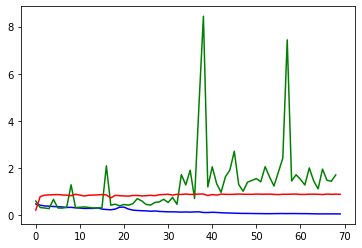

70
69
70


In [ ]:
val_loss.pop(0)

plt.plot(train_loss, 'b')
plt.plot(val_loss, 'g')
plt.plot(accuracy, 'r')
plt.show()

print(len(train_loss))
print(len(val_loss))
print(len(accuracy))

In [ ]:
model.eval()

DLAB(
  (model1_1): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent

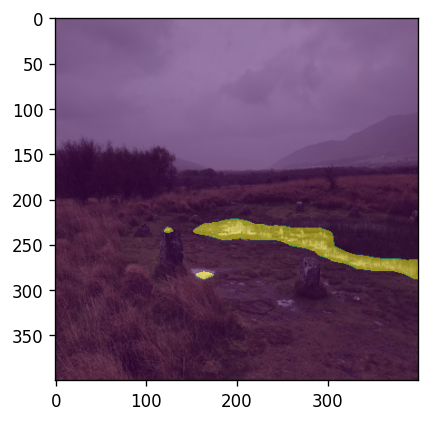

In [ ]:
example_test = Image.open(r'training_data/val_images/13.jpeg')

test_res = model(transform_test(example_test).unsqueeze(0).to(device))

plt.figure(dpi = 120) # We overlay the predicted results on the original image

plt.imshow(example_test.resize(image_size),alpha =1)

plt.imshow(torch.argmax(test_res.squeeze(),axis = 0).detach().cpu().numpy(),alpha = 0.5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Saving model to drive
model_save_name = 'model_three_segment-100e-with-validation.pt'
path = F"/content/drive/My Drive/PhD/models/model_three/{model_save_name}" 
# %ls drive/My
torch.save(model.state_dict(), path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
